# STEP:1 IEMOCAP Dataset Directory Structure

In [1]:
import os

IEMOCAP_ROOT = "IEMOCAP_full_release"  # <-- Adjust if needed

def print_dir_structure(root, max_depth=3, prefix=''):
    for root_dir, dirs, files in os.walk(root):
        depth = root_dir[len(root):].count(os.sep)
        if depth > max_depth:
            continue
        print(f"{prefix}{os.path.relpath(root_dir, root)}")
        for f in files[:5]:
            if not f.startswith('.') and not f.startswith('._'):
                print(f"{prefix}  - {f}")
        if depth == max_depth:
            dirs[:] = []  # Stop deeper traversal

def print_sample_lines(file_path, num_lines=5):
    print(f"\nSample from {file_path}:")
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            for i, line in enumerate(f):
                print(line.strip())
                if i >= num_lines - 1:
                    break
    except Exception as e:
        print(f"Could not read file: {e}")

if __name__ == "__main__":
    print("==== IEMOCAP Directory Structure (up to depth 3) ====")
    print_dir_structure(IEMOCAP_ROOT, max_depth=3, prefix='  ')

    print("\n==== Sample Files from Session 1 ====")
    session1 = os.path.join(IEMOCAP_ROOT, "Session1")

    # EmoEvaluation
    emo_eval_dir = os.path.join(session1, "dialog", "EmoEvaluation")
    if os.path.exists(emo_eval_dir):
        emo_files = [f for f in os.listdir(emo_eval_dir) if f.endswith('.txt') and not f.startswith('._')]
        if emo_files:
            print_sample_lines(os.path.join(emo_eval_dir, emo_files[0]))

    # Transcriptions
    trans_dir = os.path.join(session1, "dialog", "transcriptions")
    if os.path.exists(trans_dir):
        trans_files = [f for f in os.listdir(trans_dir) if f.endswith('.txt') and not f.startswith('._')]
        if trans_files:
            print_sample_lines(os.path.join(trans_dir, trans_files[0]))

==== IEMOCAP Directory Structure (up to depth 3) ====
  .
    - README.txt
  Session4
  Session4/sentences
  Session4/sentences/MOCAP_head
  Session4/sentences/wav
  Session4/sentences/MOCAP_rotated
  Session4/sentences/ForcedAlignment
  Session4/sentences/MOCAP_hand
  Session4/dialog
  Session4/dialog/MOCAP_head
    - Ses04M_impro06.txt
    - Ses04F_script01_2.txt
    - Ses04F_script02_2.txt
    - Ses04F_script03_1.txt
  Session4/dialog/wav
    - Ses04M_impro04.wav
    - Ses04F_impro05.wav
  Session4/dialog/transcriptions
    - Ses04M_impro06.txt
    - Ses04F_script01_2.txt
    - Ses04F_script02_2.txt
    - Ses04F_script03_1.txt
  Session4/dialog/lab
  Session4/dialog/avi
  Session4/dialog/MOCAP_rotated
    - Ses04M_impro06.txt
    - Ses04F_script01_2.txt
    - Ses04F_script02_2.txt
    - Ses04F_script03_1.txt
  Session4/dialog/MOCAP_hand
    - Ses04M_impro06.txt
    - Ses04F_script01_2.txt
    - Ses04F_script02_2.txt
    - Ses04F_script03_1.txt
  Session4/dialog/EmoEvaluation
    - S

In [2]:
#!pip install pandas

# STEP 2: Parse the emotion labels and transcripts from the IEMOCAP Dataset for all 8 emotion classes. 

In [3]:
import os
import re
import pandas as pd

IEMOCAP_ROOT = "IEMOCAP_full_release"  # Adjust as needed

# Emotions to keep
EMOTIONS = {'sur', 'fea', 'fru', 'sad', 'hap', 'exc', 'neu', 'ang'}

def parse_emo_eval_file(file_path):
    """
    Parse an EmoEvaluation .txt file to extract utterance_id and emotion label.
    Returns a dict {utterance_id: emotion}
    """
    utterance_emotions = {}
    with open(file_path, 'r', encoding='latin1') as f:
        for line in f:
            # Skip comments and empty lines
            if line.startswith('%') or not line.strip():
                continue
            # Match lines like: [6.2901 - 8.2357] Ses01F_impro01_F000 neu [2.5, 2.5, 2.5]
            match = re.match(r'\[(.*?) - (.*?)\]\s+(\S+)\s+(\S+)\s+\[.*\]', line)
            if match:
                utterance_id = match.group(3).strip()
                emotion = match.group(4).strip().lower()
                if emotion in EMOTIONS:
                    utterance_emotions[utterance_id] = emotion
    return utterance_emotions

def parse_transcript_file(file_path):
    """
    Parse a transcript .txt file to extract utterance_id and text.
    Returns a dict {utterance_id: text}
    """
    utterance_texts = {}
    with open(file_path, 'r', encoding='latin1') as f:
        for line in f:
            # Match lines like: Ses01F_impro01_F000 [006.2901-008.2357]: Excuse me.
            match = re.match(r'(\S+)\s+\[.*\]:\s+(.*)', line)
            if match:
                utterance_id = match.group(1).strip()
                text = match.group(2).strip()
                utterance_texts[utterance_id] = text
    return utterance_texts

def load_iemocap_text_data(root_dir):
    """
    Load all utterance emotions and texts from IEMOCAP dataset.
    Returns a DataFrame with columns: utterance_id, emotion, text.
    """
    data = []
    for session in range(1, 6):  # Sessions 1 to 5
        emo_eval_dir = os.path.join(root_dir, f"Session{session}", "dialog", "EmoEvaluation")
        trans_dir = os.path.join(root_dir, f"Session{session}", "dialog", "transcriptions")
        if not os.path.exists(emo_eval_dir) or not os.path.exists(trans_dir):
            continue

        # List all emotion files and transcripts
        emo_files = [f for f in os.listdir(emo_eval_dir) if f.endswith('.txt')]
        trans_files = [f for f in os.listdir(trans_dir) if f.endswith('.txt')]

        for emo_file in emo_files:
            emo_path = os.path.join(emo_eval_dir, emo_file)
            utterance_emotions = parse_emo_eval_file(emo_path)

            # Find corresponding transcript file (same name)
            if emo_file in trans_files:
                trans_path = os.path.join(trans_dir, emo_file)
                utterance_texts = parse_transcript_file(trans_path)

                # Combine emotion and text for utterances present in both
                for utt_id, emo in utterance_emotions.items():
                    if utt_id in utterance_texts:
                        data.append({
                            'utterance_id': utt_id,
                            'emotion': emo,
                            'text': utterance_texts[utt_id]
                        })

    df = pd.DataFrame(data)
    return df

if __name__ == "__main__":
    df_text = load_iemocap_text_data(IEMOCAP_ROOT)
    print(f"Total utterances loaded: {len(df_text)}")
    print("Sample data:")
    print(df_text.head())

Total utterances loaded: 7527
Sample data:
          utterance_id emotion  \
0  Ses01M_impro03_F001     sur   
1  Ses01M_impro03_F002     exc   
2  Ses01M_impro03_F003     exc   
3  Ses01M_impro03_F004     exc   
4  Ses01M_impro03_F005     exc   

                                                text  
0                                        [BREATHING]  
1                                               Why?  
2                                 Is she on the run?  
3                   Oh, she just needs to marry you.  
4  That's incredible. That's awesome. Where's she...  


# STEP 3: Creat the master CSV File and separate CSVs for text, audio and video modalities. 

In [4]:
import os
import re
import pandas as pd

IEMOCAP_ROOT = "IEMOCAP_full_release"  # Adjust as needed

# Emotions to keep and map to full names
EMOTIONS_MAP = {
    'sur': 'surprise',
    'fea': 'fear',
    'fru': 'frustration',
    'sad': 'sadness',
    'hap': 'happiness',
    'exc': 'excited',
    'neu': 'neutral',
    'ang': 'anger'
}

def parse_emo_eval_file(file_path):
    """
    Parse EmoEvaluation file to extract utterance info:
    utterance_id, emotion, start, end, dialogue
    """
    utterances = []
    with open(file_path, 'r', encoding='latin1') as f:
        for line in f:
            if line.startswith('%') or not line.strip():
                continue
            # Example line:
            # [6.2901 - 8.2357] Ses01F_impro01_F000 neu [2.5, 2.5, 2.5]
            match = re.match(r'\[(.*?) - (.*?)\]\s+(\S+)\s+(\S+)\s+\[.*\]', line)
            if match:
                start = float(match.group(1))
                end = float(match.group(2))
                utt_id = match.group(3).strip()
                emotion_abbr = match.group(4).strip().lower()
                if emotion_abbr in EMOTIONS_MAP:
                    # Extract dialogue name from utterance id (e.g. Ses01F_impro01 from Ses01F_impro01_F000)
                    dialogue = '_'.join(utt_id.split('_')[:-1])
                    utterances.append({
                        'utterance_id': utt_id,
                        'emotion': EMOTIONS_MAP[emotion_abbr],
                        'start': start,
                        'end': end,
                        'dialogue': dialogue
                    })
    return utterances

def parse_transcript_file(file_path):
    """
    Parse transcript file to get utterance_id -> text mapping
    """
    utterance_texts = {}
    with open(file_path, 'r', encoding='latin1') as f:
        for line in f:
            match = re.match(r'(\S+)\s+\[.*\]:\s+(.*)', line)
            if match:
                utt_id = match.group(1).strip()
                text = match.group(2).strip()
                utterance_texts[utt_id] = text
    return utterance_texts

def build_master_table(root_dir):
    data = []
    for session_num in range(1, 6):
        session_name = f"Session{session_num}"
        emo_eval_dir = os.path.join(root_dir, session_name, "dialog", "EmoEvaluation")
        trans_dir = os.path.join(root_dir, session_name, "dialog", "transcriptions")
        audio_base_dir = os.path.join(root_dir, session_name, "sentences", "wav")
        video_base_dir = os.path.join(root_dir, session_name, "dialog", "avi", "DivX")

        if not os.path.exists(emo_eval_dir) or not os.path.exists(trans_dir):
            print(f"Skipping {session_name} due to missing directories.")
            continue

        emo_files = [f for f in os.listdir(emo_eval_dir) if f.endswith('.txt')]
        trans_files = [f for f in os.listdir(trans_dir) if f.endswith('.txt')]

        for emo_file in emo_files:
            emo_path = os.path.join(emo_eval_dir, emo_file)
            utterances = parse_emo_eval_file(emo_path)

            # Corresponding transcript file
            if emo_file not in trans_files:
                continue
            trans_path = os.path.join(trans_dir, emo_file)
            utterance_texts = parse_transcript_file(trans_path)

            # For each utterance, collect all info and paths
            for utt in utterances:
                utt_id = utt['utterance_id']
                if utt_id not in utterance_texts:
                    continue
                text = utterance_texts[utt_id]

                # Audio path: sentences/wav/<dialogue>/<utt_id>.wav
                audio_path = os.path.join(audio_base_dir, utt['dialogue'], f"{utt_id}.wav")
                if not os.path.exists(audio_path):
                    audio_path = ""  # or None if missing

                # Video path: dialog/avi/DivX/<dialogue>.avi
                video_path = os.path.join(video_base_dir, f"{utt['dialogue']}.avi")
                if not os.path.exists(video_path):
                    video_path = ""

                data.append({
                    'session': session_name,
                    'dialogue': utt['dialogue'],
                    'utterance_id': utt_id,
                    'start': utt['start'],
                    'end': utt['end'],
                    'text': text,
                    'emotion': utt['emotion'],
                    'audio_path': audio_path,
                    'video_dialog_path': video_path
                })

    df_master = pd.DataFrame(data)
    return df_master

if __name__ == "__main__":
    df_master = build_master_table(IEMOCAP_ROOT)
    print(f"Total utterances in master table: {len(df_master)}")
    print(df_master.head())

    # Save master CSV
    master_csv_path = "iemocap_master_table.csv"
    df_master.to_csv(master_csv_path, index=False)
    print(f"Master CSV saved to {master_csv_path}")

    # Save modality-specific CSVs

    # Text only
    df_text = df_master[['utterance_id', 'text', 'emotion']]
    df_text.to_csv("iemocap_text.csv", index=False)
    print("Text CSV saved.")

    # Audio only
    df_audio = df_master[['utterance_id', 'audio_path', 'emotion']]
    df_audio.to_csv("iemocap_audio.csv", index=False)
    print("Audio CSV saved.")

    # Video only
    df_video = df_master[['utterance_id', 'video_dialog_path', 'emotion']]
    df_video.to_csv("iemocap_video.csv", index=False)
    print("Video CSV saved.")

Total utterances in master table: 7527
    session        dialogue         utterance_id  start      end  \
0  Session1  Ses01M_impro03  Ses01M_impro03_F001  10.79  12.0800   
1  Session1  Ses01M_impro03  Ses01M_impro03_F002  12.37  13.7468   
2  Session1  Ses01M_impro03  Ses01M_impro03_F003  16.19  17.7425   
3  Session1  Ses01M_impro03  Ses01M_impro03_F004  19.60  22.1975   
4  Session1  Ses01M_impro03  Ses01M_impro03_F005  26.00  33.2100   

                                                text   emotion  \
0                                        [BREATHING]  surprise   
1                                               Why?   excited   
2                                 Is she on the run?   excited   
3                   Oh, she just needs to marry you.   excited   
4  That's incredible. That's awesome. Where's she...   excited   

                                          audio_path  \
0  IEMOCAP_full_release/Session1/sentences/wav/Se...   
1  IEMOCAP_full_release/Session1/sentences/

In [5]:
#!pip install imblearn

# STEP 4: Analyze and Balance emotion label distribution for text modality

In [6]:
import pandas as pd
from collections import Counter
from imblearn.over_sampling import RandomOverSampler

# Load text CSV
df_text = pd.read_csv("iemocap_text.csv")
print("Original emotion distribution:")
print(df_text['emotion'].value_counts())

# Prepare features and labels
X = df_text['text'].values.reshape(-1, 1)  # Reshape for oversampler
y = df_text['emotion'].values

# Initialize oversampler
ros = RandomOverSampler(random_state=42)

# Apply oversampling
X_resampled, y_resampled = ros.fit_resample(X, y)

# Create balanced DataFrame
df_text_balanced = pd.DataFrame({
    'text': X_resampled.flatten(),
    'emotion': y_resampled
})

print("\nBalanced emotion distribution:")
print(df_text_balanced['emotion'].value_counts())

# Save balanced text CSV
df_text_balanced.to_csv("iemocap_text_balanced.csv", index=False)
print("\nBalanced text CSV saved as 'iemocap_text_balanced.csv'")

Original emotion distribution:
emotion
frustration    1849
neutral        1708
anger          1103
sadness        1084
excited        1041
happiness       595
surprise        107
fear             40
Name: count, dtype: int64

Balanced emotion distribution:
emotion
surprise       1849
excited        1849
neutral        1849
anger          1849
frustration    1849
sadness        1849
happiness      1849
fear           1849
Name: count, dtype: int64

Balanced text CSV saved as 'iemocap_text_balanced.csv'


/home/aiml/miniconda3/envs/torch_gpu/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/aiml/miniconda3/envs/torch_gpu/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/home/aiml/miniconda3/envs/torch_gpu/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


# STEP 5: Text preprocessing and Feature Extraction

In [7]:
import pandas as pd
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Load balanced text CSV
df = pd.read_csv("iemocap_text_balanced.csv")

# Text cleaning function
def clean_text(text):
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Optionally, remove extra whitespace
    text = ' '.join(text.split())
    return text

# Apply cleaning
df['clean_text'] = df['text'].apply(clean_text)

# TF-IDF Vectorizer (limit max features for CPU efficiency)
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

# Fit and transform
X_tfidf = tfidf.fit_transform(df['clean_text'])

# Labels
y = df['emotion']

# Split into train and test sets (e.g., 80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

print(f"TF-IDF feature matrix shape: {X_tfidf.shape}")
print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")

# Save TF-IDF vectorizer and datasets if needed
import joblib
joblib.dump(tfidf, "tfidf_vectorizer.joblib")
print("TF-IDF vectorizer saved as 'tfidf_vectorizer.joblib'")

# Optionally save train/test splits (sparse matrices)
import scipy.sparse
scipy.sparse.save_npz("X_train_tfidf.npz", X_train)
scipy.sparse.save_npz("X_test_tfidf.npz", X_test)
y_train.to_csv("y_train.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

print("Train/test splits saved.")

TF-IDF feature matrix shape: (14792, 5000)
Training samples: 11833, Test samples: 2959
TF-IDF vectorizer saved as 'tfidf_vectorizer.joblib'
Train/test splits saved.


In [8]:
#!pip install seaborn

# STEP 6: Train and Evaluate a Text-only classifier TF-IDF features + SVM Classifier

Test Accuracy: 0.7699
Test Macro F1-score: 0.7620

Classification Report:
              precision    recall  f1-score   support

       anger       0.72      0.78      0.75       370
     excited       0.79      0.79      0.79       369
        fear       0.94      1.00      0.97       370
 frustration       0.59      0.44      0.50       370
   happiness       0.83      0.83      0.83       370
     neutral       0.63      0.55      0.59       370
     sadness       0.76      0.79      0.77       370
    surprise       0.81      0.98      0.89       370

    accuracy                           0.77      2959
   macro avg       0.76      0.77      0.76      2959
weighted avg       0.76      0.77      0.76      2959



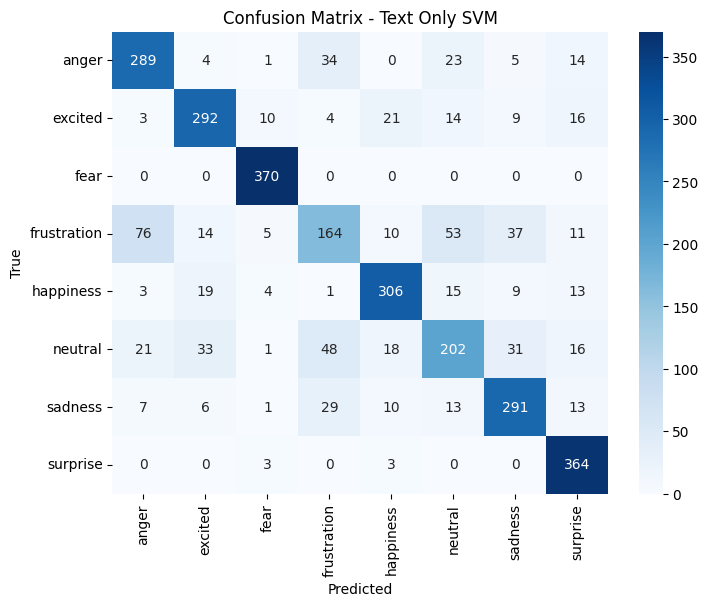

In [9]:
import joblib
import pandas as pd
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import scipy.sparse
import matplotlib.pyplot as plt
import seaborn as sns

# Load train/test data
X_train = scipy.sparse.load_npz("X_train_tfidf.npz")
X_test = scipy.sparse.load_npz("X_test_tfidf.npz")
y_train = pd.read_csv("y_train.csv")['emotion']
y_test = pd.read_csv("y_test.csv")['emotion']

# Initialize and train Linear SVM
clf = LinearSVC(random_state=42, max_iter=10000)
clf.fit(X_train, y_train)

# Predict on test set
y_pred = clf.predict(X_test)

# Evaluation
acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
print(f"Test Accuracy: {acc:.4f}")
print(f"Test Macro F1-score: {f1_macro:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=clf.classes_, yticklabels=clf.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Text Only SVM')
plt.show()

In [10]:
#!pip install transformers

# STEP 7: BERT Pipeline Code:-

In [11]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertForSequenceClassification
from torch.optim import AdamW  # Use PyTorch native AdamW
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
import numpy as np
from tqdm.auto import tqdm  # tqdm for progress bars

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load balanced text data
df = pd.read_csv("iemocap_text_balanced.csv")

# Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['emotion'])
num_labels = len(label_encoder.classes_)
print(f"Labels: {list(label_encoder.classes_)}")

# Train-test split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42, stratify=df['label']
)

# Tokenizer and model
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

class IEMOCAPDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create datasets and dataloaders
train_dataset = IEMOCAPDataset(train_texts, train_labels, tokenizer)
val_dataset = IEMOCAPDataset(val_texts, val_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Load pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)
model.to(device)

# Optimizer (PyTorch native AdamW)
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training function with tqdm progress bar
def train_epoch(model, data_loader, optimizer):
    model.train()
    total_loss = 0
    loop = tqdm(data_loader, desc="Training", leave=False)
    for batch in loop:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        loop.set_postfix(loss=loss.item())
    return total_loss / len(data_loader)

# Evaluation function with tqdm progress bar
def eval_model(model, data_loader):
    model.eval()
    preds = []
    true_labels = []
    loop = tqdm(data_loader, desc="Evaluating", leave=False)
    with torch.no_grad():
        for batch in loop:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            preds.extend(predictions.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    acc = accuracy_score(true_labels, preds)
    f1 = f1_score(true_labels, preds, average='macro')
    report = classification_report(true_labels, preds, target_names=label_encoder.classes_)
    return acc, f1, report

# Training loop
epochs = 5
for epoch in range(epochs):
    train_loss = train_epoch(model, train_loader, optimizer)
    val_acc, val_f1, val_report = eval_model(model, val_loader)
    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Val Acc: {val_acc:.4f} - Val F1: {val_f1:.4f}")

print("\nValidation Classification Report:\n", val_report)

# Save fine-tuned model and tokenizer
model.save_pretrained("bert_finetuned_iemocap")
tokenizer.save_pretrained("bert_finetuned_iemocap")
print("Model and tokenizer saved to 'bert_finetuned_iemocap'")

/home/aiml/miniconda3/envs/torch_gpu/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
Labels: ['anger', 'excited', 'fear', 'frustration', 'happiness', 'neutral', 'sadness', 'surprise']


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
                                                                                

Epoch 1/5 - Train Loss: 1.1834 - Val Acc: 0.7148 - Val F1: 0.7081


Epoch 2/5 - Train Loss: 0.6597 - Val Acc: 0.7783 - Val F1: 0.7715


Epoch 3/5 - Train Loss: 0.4728 - Val Acc: 0.7962 - Val F1: 0.7910


Epoch 4/5 - Train Loss: 0.3632 - Val Acc: 0.7986 - Val F1: 0.7912


Epoch 5/5 - Train Loss: 0.3068 - Val Acc: 0.8148 - Val F1: 0.8085

Validation Classification Report:
               precision    recall  f1-score   support

       anger       0.77      0.82      0.80       370
     excited       0.83      0.85      0.84       369
        fear       0.95      1.00      0.97       370
 frustration       0.63      0.47      0.54       370
   happiness       0.92      0.89      0.90       370
     neutral       0.68      0.62      0.65       370
     sadness       0.78      0.91      0.84       370
    surprise       0.90      0.96      0.93       370

    accuracy                           0.81      2959
   macro avg       0.81      0.81      0.81      2959
weighted avg       0.81      0.81      0.81      2959

Model and tokenizer saved to 'bert_finetuned_iemocap'


# STEP 8: Extract [CLS] Embedding for fusion

In [12]:
# Optional: Extract [CLS] embeddings for fusion
def extract_cls_embeddings(model, data_loader):
    model.eval()
    embeddings = []
    labels = []
    loop = tqdm(data_loader, desc="Extracting CLS embeddings", leave=False)
    with torch.no_grad():
        for batch in loop:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels.extend(batch['labels'].numpy())
            outputs = model.bert(input_ids, attention_mask=attention_mask)
            cls_embeds = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.append(cls_embeds)
    embeddings = np.vstack(embeddings)
    return embeddings, np.array(labels)

train_embeddings, train_labels = extract_cls_embeddings(model, train_loader)
val_embeddings, val_labels = extract_cls_embeddings(model, val_loader)

# Save embeddings for fusion
np.save("bert_train_embeddings.npy", train_embeddings)
np.save("bert_val_embeddings.npy", val_embeddings)
np.save("bert_train_labels.npy", train_labels)
np.save("bert_val_labels.npy", val_labels)
print("Extracted CLS embeddings saved for fusion.")

Extracted CLS embeddings saved for fusion.


# STEP 9: Plot Training and Validation Accuracy per epoch and report test accuracy

Epoch 1/5 - Train Loss: 0.2657 - Val Acc: 0.8124 - Val F1: 0.8019


Epoch 2/5 - Train Loss: 0.2444 - Val Acc: 0.7982 - Val F1: 0.7829


Epoch 3/5 - Train Loss: 0.2186 - Val Acc: 0.8094 - Val F1: 0.8040


Epoch 4/5 - Train Loss: 0.2147 - Val Acc: 0.8165 - Val F1: 0.8098


Epoch 5/5 - Train Loss: 0.2093 - Val Acc: 0.8158 - Val F1: 0.8104


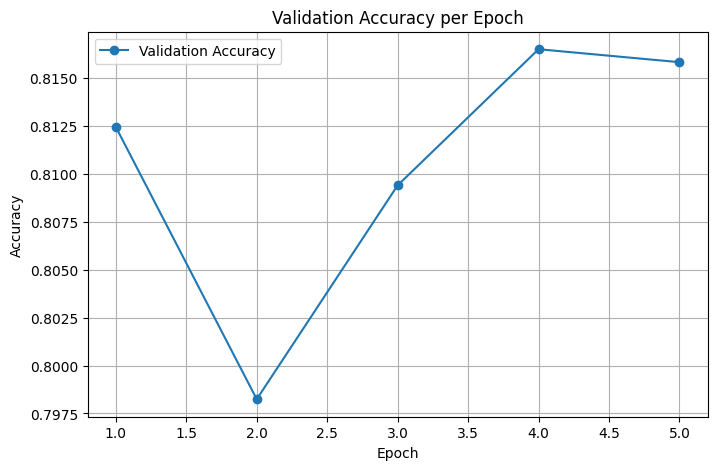


Final Validation Classification Report:
               precision    recall  f1-score   support

       anger       0.77      0.87      0.82       370
     excited       0.83      0.85      0.84       369
        fear       0.94      1.00      0.97       370
 frustration       0.62      0.52      0.56       370
   happiness       0.93      0.92      0.92       370
     neutral       0.63      0.57      0.60       370
     sadness       0.86      0.81      0.83       370
    surprise       0.90      0.99      0.94       370

    accuracy                           0.82      2959
   macro avg       0.81      0.82      0.81      2959
weighted avg       0.81      0.82      0.81      2959

Final Validation Accuracy: 0.8158


In [13]:
import matplotlib.pyplot as plt

train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    train_loss = train_epoch(model, train_loader, optimizer)
    val_acc, val_f1, val_report = eval_model(model, val_loader)
    train_accuracies.append(None)  # If you want, you can implement train accuracy calculation similarly
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Val Acc: {val_acc:.4f} - Val F1: {val_f1:.4f}")

# Plot validation accuracy
plt.figure(figsize=(8,5))
plt.plot(range(1, epochs+1), val_accuracies, marker='o', label='Validation Accuracy')
plt.title('Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

print("\nFinal Validation Classification Report:\n", val_report)
print(f"Final Validation Accuracy: {val_accuracies[-1]:.4f}")

# STEP 10: Code for Inference: Predict Emotion from user Input Text with Confidence Scores.

In [14]:
import torch
import numpy as np

# Load saved model and tokenizer
from transformers import BertTokenizerFast, BertForSequenceClassification

model_path = "bert_finetuned_iemocap"
tokenizer = BertTokenizerFast.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)
model.to(device)
model.eval()

# Label encoder inverse mapping
label_map = {i: label for i, label in enumerate(label_encoder.classes_)}

def predict_emotion(text, true_label=None):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding='max_length', max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
        pred_idx = np.argmax(probs)
        pred_label = label_map[pred_idx]
        confidence = probs[pred_idx]

    print(f"Input Text: {text}")
    if true_label:
        print(f"True Label: {true_label}")
    print(f"Predicted Emotion: {pred_label} (Confidence: {confidence:.4f})")
    print("All class probabilities:")
    for i, label in label_map.items():
        print(f"  {label}: {probs[i]:.4f}")
    return pred_label, confidence
   # predict_emotion("I am so happy and excited today!", true_label="happiness") # Example usage:

In [16]:
predict_emotion("Like what? Like a birth certificate?")

Input Text: Like what? Like a birth certificate?
Predicted Emotion: frustration (Confidence: 0.9344)
All class probabilities:
  anger: 0.0293
  excited: 0.0002
  fear: 0.0004
  frustration: 0.9344
  happiness: 0.0001
  neutral: 0.0335
  sadness: 0.0016
  surprise: 0.0004


('frustration', 0.93441546)

In [18]:
predict_emotion("You never listen to me, no matter how many times I say it!")

Input Text: You never listen to me, no matter how many times I say it!
Predicted Emotion: anger (Confidence: 0.8560)
All class probabilities:
  anger: 0.8560
  excited: 0.0004
  fear: 0.0004
  frustration: 0.1307
  happiness: 0.0003
  neutral: 0.0091
  sadness: 0.0023
  surprise: 0.0007


('anger', 0.8560365)

In [21]:
#!pip install wordcloud

# STEP 11: Word Cloud per Session

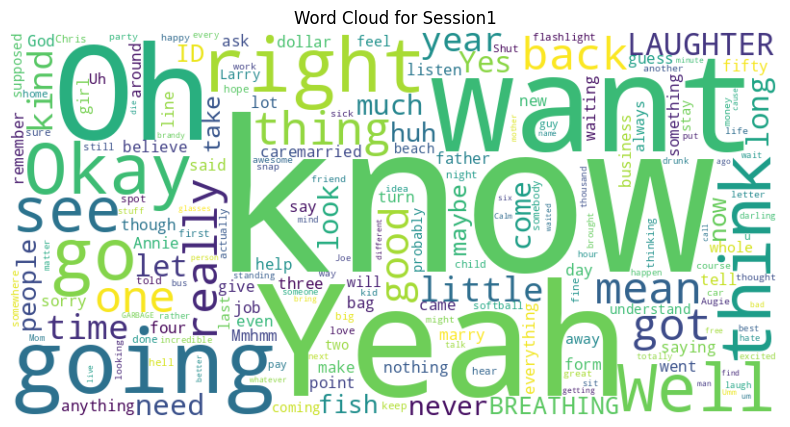

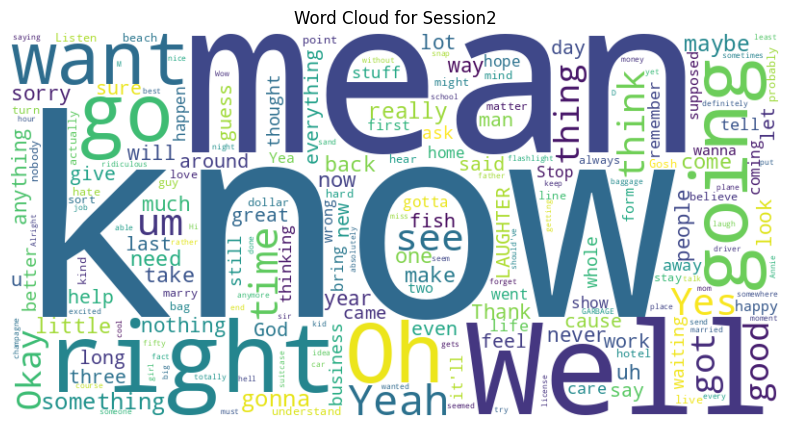

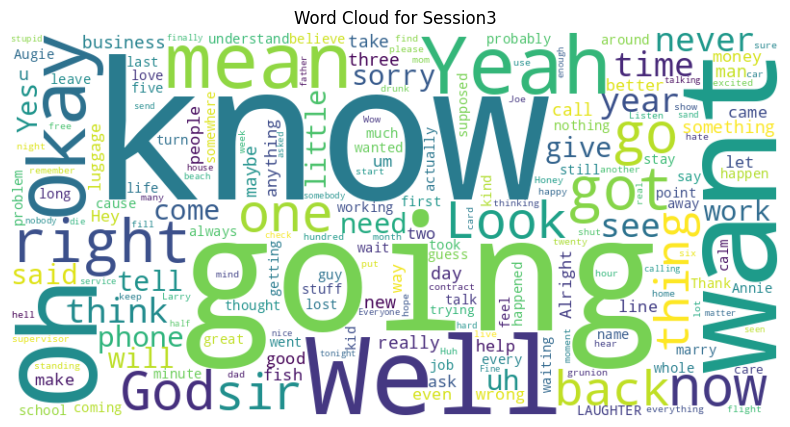

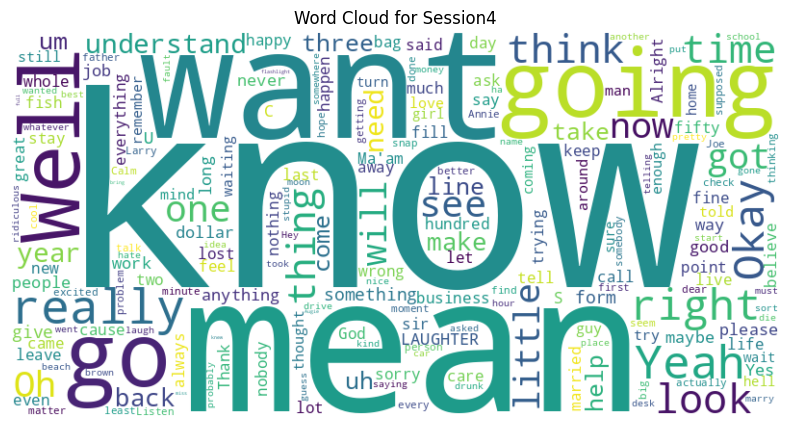

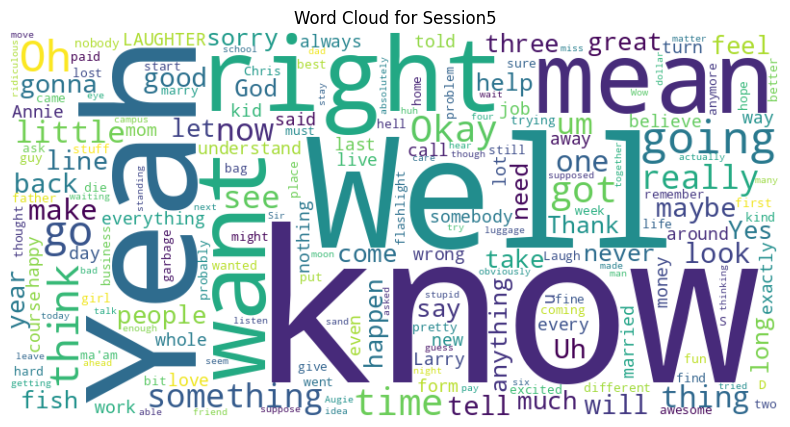

In [22]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# Assuming df_master is your master dataframe with 'session' and 'text' columns
stopwords = set(STOPWORDS)

for session_name, group in df_master.groupby('session'):
    text = " ".join(group['text'].values)
    wordcloud = WordCloud(width=800, height=400, background_color='white',
                          stopwords=stopwords, collocations=False).generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for {session_name}")
    plt.show()

In [23]:
model.save_pretrained("bert_finetuned_iemocap")
tokenizer.save_pretrained("bert_finetuned_iemocap")
print("Model and tokenizer saved to 'bert_finetuned_iemocap'")

Model and tokenizer saved to 'bert_finetuned_iemocap'
